In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
block_size = 5

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.shuffle(words)
train_split = int(.8*len(words))
test_split = int(.9*len(words))

train_X, train_Y = build_dataset(words[:train_split])
val_X, val_Y = build_dataset(words[train_split:test_split])
test_X, test_Y = build_dataset(words[test_split:])

train_X.shape, val_X.shape, test_X.shape

(torch.Size([182574, 5]), torch.Size([22729, 5]), torch.Size([22843, 5]))

In [ ]:
emb_dim = 20
hidden_units = 300

C = torch.randn((27, emb_dim),)
W1 = torch.randn((emb_dim*block_size, hidden_units),) * (5/3) / (emb_dim*block_size)**5
# B1 = torch.randn((hidden_units),) * 0.01
W2 = torch.randn((hidden_units, 27),) * 0.01
B2 = torch.randn((27),) * 0

bngain = torch.ones((1, hidden_units))
bnbias = torch.zeros((1, hidden_units))
bnmean_running = torch.zeros((1, hidden_units))
bnstd_running = torch.ones((1, hidden_units))

parameters = [C, W1, W2, B2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [ ]:
epochs = 300000
batch_size = 64

for epoch in range(epochs):
    batch = torch.randint(0, train_X.shape[0], (batch_size,))
    emb = C[train_X[batch]]
    hpreact = emb.view(emb.shape[0], -1) @ W1

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani)/bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, train_Y[batch])

    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if epoch < 200000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.1895253658294678


In [11]:
emb = C[train_X]
hpreact = emb.view(emb.shape[0], -1) @ W1
hpreact = bngain * ((hpreact - bnmean_running)/bnstd_running) + bnbias
h = torch.tanh(hpreact)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, train_Y)
print(loss.item())

2.0927844047546387


In [13]:
emb = C[val_X]
hpreact = emb.view(emb.shape[0], -1) @ W1
hpreact = bngain * ((hpreact - bnmean_running)/bnstd_running) + bnbias
h = torch.tanh(hpreact)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, val_Y)
print(loss.item())

2.122685432434082


In [56]:
class Linear():
    def __init__(self, in_features, out_features, bias=True):
        self.W = torch.randn((in_features, out_features)) / in_features**.5
        self.bias = torch.zeros((out_features)) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.W 
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.bias is None else [self.bias])


In [24]:
class BatchNorm1D():
    def __init__(self, num_features, eps=1e-05, momentum=0.001):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)

        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
    
    def __call__(self, x: torch.Tensor):
        if self.training:
            xvar = x.var(0, keepdim=True, unbiased=True)
            xmean = x.mean(0, keepdim=True)
        else:
            xvar = self.running_var
            xmean = self.running_mean
        xhat = (x - xmean ) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_gamma = (1-self.momentum) * self.running_gamma + self.momentum * xmean
                self.running_beta = (1-self.momentum) * self.running_beta + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [57]:
class tanh():    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [93]:
n_embd = 10
n_hidden = 100

C = torch.randn((27, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), tanh(),
    Linear(n_hidden, n_hidden), tanh(),
    Linear(n_hidden, n_hidden), tanh(),
    Linear(n_hidden, n_hidden), tanh(),
    Linear(n_hidden, n_hidden), tanh(),
    Linear(n_hidden, 27)
]

with torch.no_grad():
    # Make last layer weights closer to 0
    layers[-1].W *= .1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # Kaiming Init
            layer.W *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

In [94]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    emb = C[train_X[ix]]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, train_Y[ix])

    for layer in layers: # Temp Debugging
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"Epoch: {i} | Loss: {loss.item()}")

    lossi.append(loss.log10().item())
    break; # DEBUG Step

Epoch: 0 | Loss: 3.2965474128723145


layer 1 (      tanh): mean -0.04, std 0.76, saturated: 23.28%
layer 3 (      tanh): mean +0.01, std 0.68, saturated: 9.00%
layer 5 (      tanh): mean +0.03, std 0.66, saturated: 7.78%
layer 7 (      tanh): mean +0.02, std 0.65, saturated: 6.16%
layer 9 (      tanh): mean +0.01, std 0.64, saturated: 4.59%


Text(0.5, 1.0, 'activation distribution')

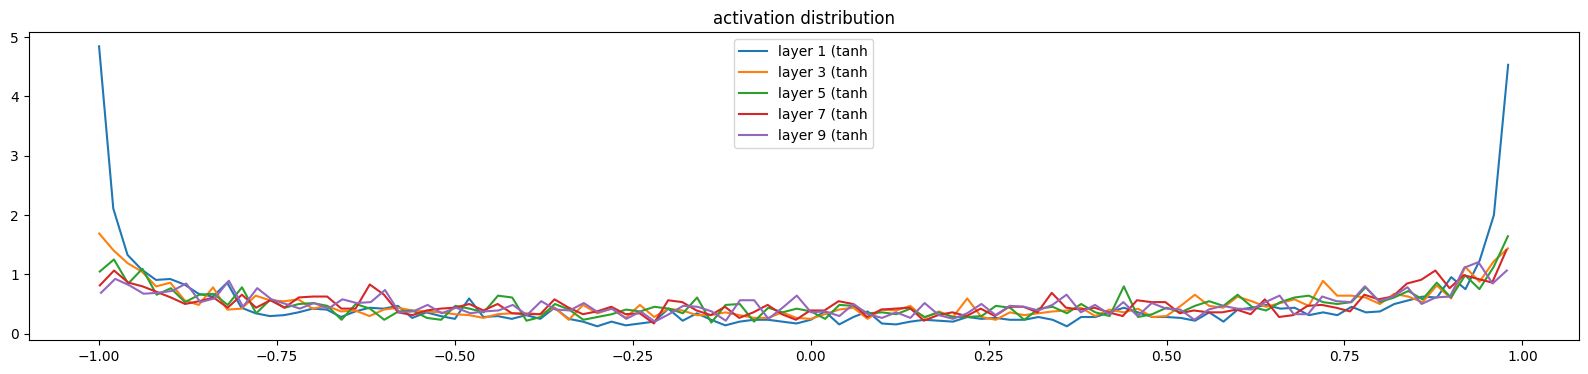

In [95]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      tanh): mean +0.000055, std 4.395875e-03
layer 3 (      tanh): mean -0.000119, std 3.790194e-03
layer 5 (      tanh): mean -0.000007, std 3.473007e-03
layer 7 (      tanh): mean +0.000053, std 3.656141e-03
layer 9 (      tanh): mean -0.000097, std 3.608329e-03


Text(0.5, 1.0, 'gradient distribution')

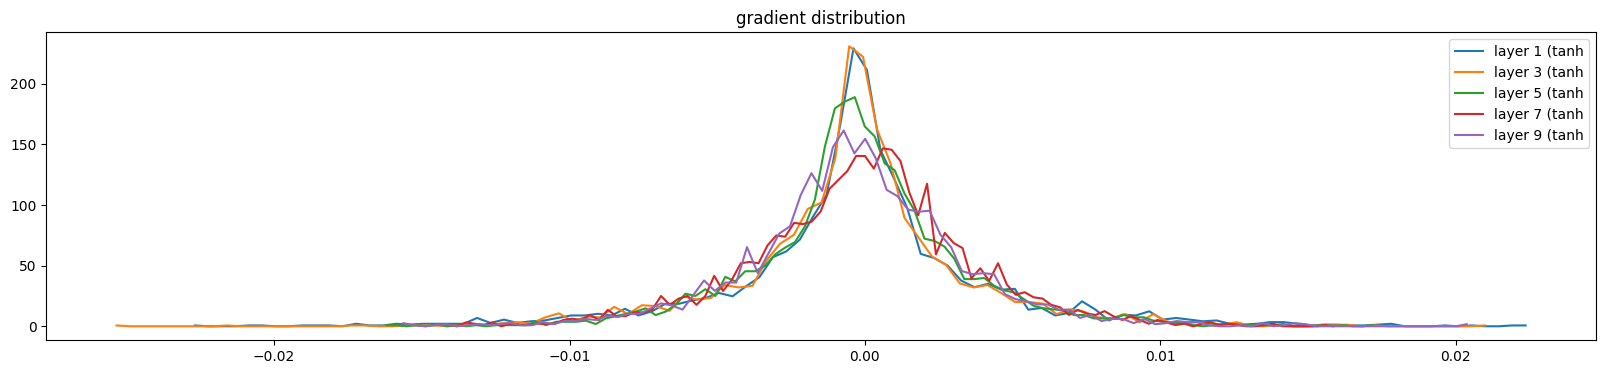

In [91]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000043 | std 1.153337e-03 | grad:data ratio 1.183970e-03
weight  (50, 100) | mean +0.000043 | std 1.491914e-03 | grad:data ratio 6.342935e-03
weight (100, 100) | mean +0.000000 | std 1.186421e-03 | grad:data ratio 7.086353e-03
weight (100, 100) | mean +0.000001 | std 1.007115e-03 | grad:data ratio 6.046395e-03
weight (100, 100) | mean -0.000004 | std 9.177825e-04 | grad:data ratio 5.510538e-03
weight (100, 100) | mean -0.000005 | std 8.346076e-04 | grad:data ratio 5.052123e-03
weight  (100, 27) | mean -0.000000 | std 2.386555e-02 | grad:data ratio 2.305224e+00


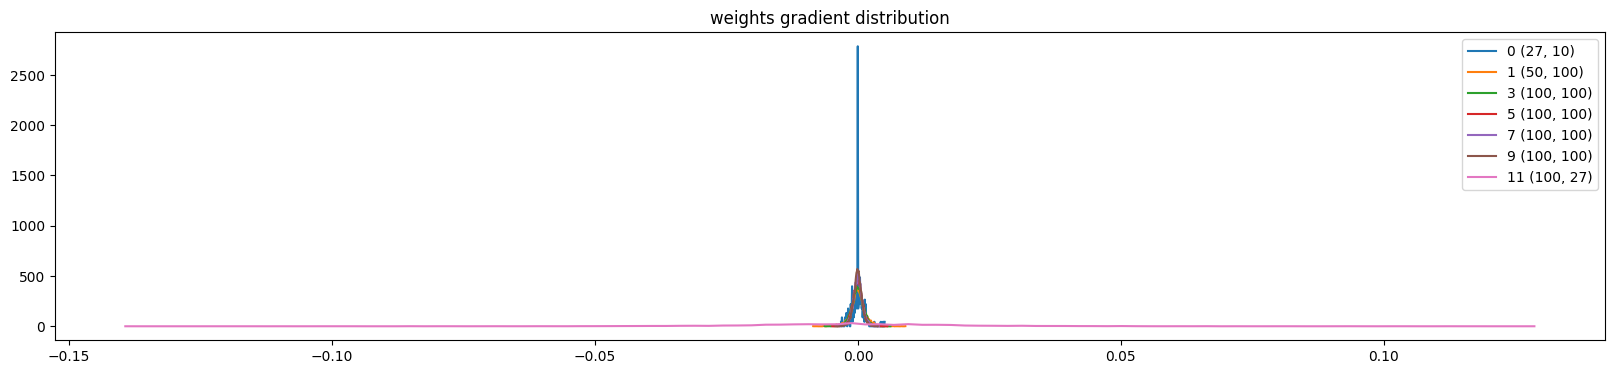

: 

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [73]:
# Train Loss
with torch.no_grad():
    emb = C[train_X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, train_Y)
    print(f"Train Loss: {loss.item()}")

# Val Loss
with torch.no_grad():
    emb = C[val_X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, val_Y)
    print(f"Validation Loss: {loss.item()}")

Train Loss: 3.2609941959381104
Validation Loss: 3.259798526763916
